If you have any questions, you can join the `QQ group:790699378`, or `create an issue` in the nncase repo:[click here](https://github.com/kendryte/nncase/issues)

# 1. Install libs and set python env

In [ ]:
!pip install --upgrade pip
!pip install nncase --timeout=1000
!pip install nncase-kpu --timeout=1000
!pip install onnx onnxsim scikit-learn

# # nncase-2.x need dotnet-7
# # Ubuntu use apt to install dotnet-7.0 (The docker has installed dotnet7.0)
!sudo apt-get install -y dotnet-sdk-7.0

In [ ]:
# ubuntu
%env PATH=$PATH:/usr/local/lib/python3.7/site-packages

* In Windows OS
> You need to add the path where nncase packages were installed into `PATH` environment variable.
After it, you need to restart your `CMD`. 

# 2. Set compile options and PTQ options (quantize model)

You can find more details about [preprocess args](https://github.com/kendryte/nncase/blob/master/docs/USAGE_v2_EN.md#CompileOptions), [quantize options](https://github.com/kendryte/nncase/blob/master/docs/USAGE_v2_EN.md#PTQTensorOptions) and [Mix quantize](https://github.com/kendryte/nncase/blob/master/docs/MixQuant.md).

In [ ]:
import nncase
import numpy as np
from nncase_base_func import *

def compile_kmodel(model_path, dump_path, calib_data):
    """
    Set compile options and ptq options.
    Compile kmodel.
    Dump the compile-time result to 'compile_options.dump_dir'
    """
    print("\n----------   compile    ----------")
    print("Simplify...")
    model_file = model_simplify(model_path)

    print("Set options...")
    # import_options
    import_options = nncase.ImportOptions()

    ############################################
    # The code below, you need to modify to fit your model.
    # You can find more details about these options in docs/USAGE_v2.md.
    ############################################
    # compile_options
    compile_options = nncase.CompileOptions()
    compile_options.target = "k230" #"cpu"
    compile_options.dump_ir = False  # if False, will not dump the compile-time result.
    compile_options.dump_asm = True
    compile_options.dump_dir = dump_path
    compile_options.input_file = ""
    
    # preprocess args
    compile_options.preprocess = False
    if compile_options.preprocess:
        compile_options.input_type = "uint8" # "uint8" "float32"
        compile_options.input_shape = [1,224,320,3]
        compile_options.input_range = [0,1]
        compile_options.input_layout = "NHWC" # "NHWC"
        compile_options.swapRB = False
        compile_options.mean = [0,0,0]
        compile_options.std = [1,1,1]
        compile_options.letterbox_value = 0
        compile_options.output_layout = "NHWC" # "NHWC"

    # quantize options
    ptq_options = nncase.PTQTensorOptions()
    ptq_options.quant_type = "uint8" # datatype : "float32", "int8", "int16"
    ptq_options.w_quant_type = "uint8"  # datatype : "float32", "int8", "int16"
    ptq_options.calibrate_method = "NoClip" # "Kld"
    ptq_options.finetune_weights_method = "NoFineTuneWeights"
    ptq_options.dump_quant_error = False
    ptq_options.dump_quant_error_symmetric_for_signed = False

    # mix quantize options
    # more details in docs/MixQuant.md
    ptq_options.quant_scheme = ""
    ptq_options.export_quant_scheme = False
    ptq_options.export_weight_range_by_channel = False
    ############################################
    
    ptq_options.samples_count = len(calib_data[0])
    ptq_options.set_tensor_data(calib_data)
    
    print("Compiling...")
    compiler = nncase.Compiler(compile_options)
    # import
    model_content = read_model_file(model_file)
    if model_path.split(".")[-1] == "onnx":
        compiler.import_onnx(model_content, import_options)
    elif model_path.split(".")[-1] == "tflite":
        compiler.import_tflite(model_content, import_options)
    
    compiler.use_ptq(ptq_options)
    
    # compile
    compiler.compile()
    kmodel = compiler.gencode_tobytes()
    
    kmodel_path = os.path.join(dump_path, "test.kmodel")
    with open(kmodel_path, 'wb') as f:
        f.write(kmodel)
    print("----------------end-----------------")
    return kmodel_path


# 3. Compile model with a single input.
Before all, we need to get the input and output infos of model. <br>
Open [netron](https://netron.app), and click 'open model' to select your model.<br>
Click the input node, you will see the details of model's input and output.<br>
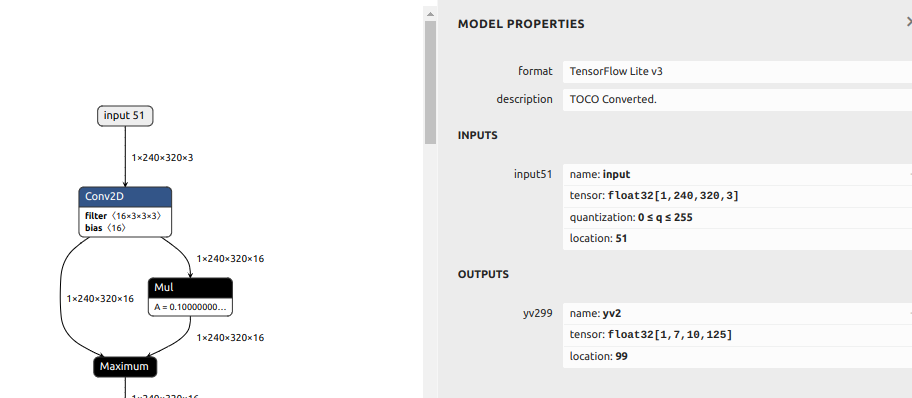 <br>

Before compiling kmodel, we should set the `CompileOptions` and `PTQTensorOptions` to specify the attribute of kmodel.

Then, we can set the `model_path`, `dump_path`, and `calib_data`. <br>
The calib_data format is `[[x1, x2,...]]`. <br>

In [ ]:
# compile kmodel single input
model_path = "./test.tflite"
dump_path = "./tmp_tflite"

# sample_count is 2
calib_data = [[np.random.rand(1, 240, 320, 3).astype(np.float32), np.random.rand(1, 240, 320, 3).astype(np.float32)]]

kmodel_path = compile_kmodel(model_path, dump_path, calib_data)


# 4. Simulate kmodel with a single input.
Set `kmodel_path` and `input_data`. After running, it will print shape of result. And result will be stored in `dump_path`.

In [ ]:
# run kmodel(simulate)
import os

kmodel_path = "./tmp_tflite/test.kmodel"
input_data = [np.random.rand(1, 240, 320, 3).astype(np.float32)]

result = run_kmodel(kmodel_path, input_data)

for idx, i in enumerate(result):
    print(i.shape)
    i.tofile(os.path.join(dump_path,"nncase_result_{}.bin".format(idx)))

# 5. Compare kmodel result and tflite result.

Here, we will use the TensorFlow framework to infer model(`.tflite`, not kmodel). And calculate the cosine between the tflite result and kmodel result.

In [ ]:
!pip install tensorflow
import tensorflow as tf
interp = tf.lite.Interpreter(model_path=model_path)

inputs = []
for idx, item in enumerate(interp.get_input_details()):
    input_dict = {}
    input_dict['index'] = item['index']
    input_dict['value'] = input_data[idx]
    inputs.append(input_dict)
    
# print(input_dict)

interp.allocate_tensors()
for input in inputs:
    interp.set_tensor(input['index'], input['value'])
interp.invoke()

tflite_result = []
for item in interp.get_output_details():
    tflite_result.append(interp.get_tensor(item['index']))

for index, (i, j) in enumerate(zip(tflite_result, result)):
    print("result {} cosine = ".format(index), get_cosine(i, j))


# 6. Compile model with multiple inputs.

After reading [Example of compiling model with a single input](#Example_of_compiling_model_with_a_single_input), you know how to set calib_data for a single input.<br>
We will show you how to create a calib_data when your model has more inputs.<br>
If model has multiple inputs, calib_data format is `[[x1, x2,...], [y1, y2,...], ...]`. <br>
```
e.g. Model has three inputs (x, y, z), and these inputs info are like this.
x:{shape: [3,100], range: [1,5], dtype: int64}
y:{shape: [100, 3, 192], range: [0,1), dtype: float32}
z:{shape: [3,100], dtype: bool}

The calib_data will be like the one below.

calib_data = [
[ np.random.randint(1, 5, size=[3,100], dtype='int64'), np.random.randint(1, 5, size=[3,100], dtype='int64')],
[ np.random.rand(100, 3, 192).astype(np.float32), np.random.rand(100, 3, 192).astype(np.float32)],
[ np.random.rand(3,100).astype(np.float32)>0.5, np.random.rand(3,100).astype(np.float32)>0.5],] # bool
```

Here, we will use an easier model to show you how to do it. <br>
The model is shown below.<br>
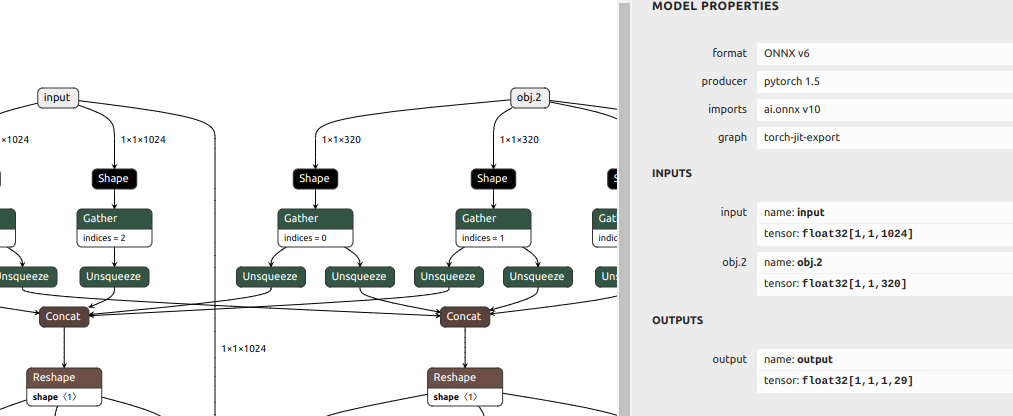


In [ ]:
# compile kmodel multiple inputs
model_path = "./test.onnx"
dump_path = "./tmp_onnx"

# sample_count is 2
calib_data = [[np.random.rand(1, 1, 1024).astype(np.float32), np.random.rand(1, 1, 1024).astype(np.float32)],
              [np.random.rand(1, 1, 320).astype(np.float32), np.random.rand(1, 1, 320).astype(np.float32)]]

kmodel_path = compile_kmodel(model_path, dump_path, calib_data)



# 7. Simulate kmodel with multiple inputs.

Simulate kmodel on PC.

In [ ]:
# run kmodel(simulate)
import os

kmodel_path = "./tmp_onnx/test.kmodel"
input_data = [np.random.rand(1, 1, 1024).astype(np.float32), np.random.rand(1, 1, 320).astype(np.float32)]

results = run_kmodel(kmodel_path, input_data)

for idx, i in enumerate(results):
    print(i.shape)
    i.tofile(os.path.join(dump_path,"nncase_result_{}.bin".format(idx)))


# 8. Compare kmodel results and onnx results.

Here, we will use the ONNX framework to infer model(`.onnx`, not kmodel). And calculate the cosine between the ONNX result and the kmodel result.

In [ ]:
!pip install onnxruntime
import onnxruntime as rt

# onnx_model = model_simplify(model_path)
onnx_model = model_path
_, input_info = parse_model_input_output(model_path)
onnx_sess = rt.InferenceSession(onnx_model)

input_dict = {}
for i, info in enumerate(input_info):
    print(info['shape'])
    input_dict[info["name"]] = input_data[i]

onnx_results = onnx_sess.run(None, input_dict)
for index, (i, j) in enumerate(zip(onnx_results, results)):
    print("result {} cosine = ".format(index), get_cosine(i, j))